In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
IGNORE_IDS = [38]
results_dir = Path("./results/TAG-Benchmark")

In [3]:
# # DuckDB UDFs
# all_latencies = []
# sample_level_latencies = []
# curr_df_a = pd.read_csv(results_dir / "duckdb/Meta-Llama-3.1-8B-Instruct.Q6_K.gguf/pt1/predictions.csv")
# curr_df_b = pd.read_csv(results_dir / "duckdb/Meta-Llama-3.1-8B-Instruct.Q6_K.gguf/pt2/predictions.csv")
# fill_in_row = pd.DataFrame(
#     {
#         "Query ID": [29],
#         "latency": 0
#     }
# )
# curr_df = pd.concat([curr_df_a, curr_df_b, fill_in_row])
# curr_df = curr_df[~curr_df["Query ID"].isin(IGNORE_IDS)]
# all_latencies.append(curr_df["latency"].mean())
# sample_level_latencies.append(curr_df["latency"].tolist())
# all_latencies = np.array(all_latencies)
# print(all_latencies.mean())
# print(all_latencies.std())
# avg_sample_level_duckdb = np.array(sample_level_latencies).mean(axis=0)
# query_ids = curr_df['Query ID'].tolist()

133.24748503511603
0.0


In [3]:
all_latencies = []
sample_level_latencies = []
for f in (results_dir / "blendsql").iterdir():
    if f.name.startswith("predictions"):
        curr_df = pd.read_csv(f)
        curr_df = curr_df[~curr_df["Query ID"].isin(IGNORE_IDS)]
        # curr_df = curr_df[curr_df["Query ID"].isin(query_ids)]
        all_latencies.append(curr_df["latency"].mean())
        sample_level_latencies.append(curr_df["latency"].tolist())
all_latencies = np.array(all_latencies)
print(all_latencies.mean())
print(all_latencies.std())
avg_sample_level_blendsql = np.array(sample_level_latencies).mean(axis=0)
query_ids = curr_df['Query ID'].tolist()

0.7779849610086215
0.018301983865903704


In [4]:
all_latencies = []
sample_level_latencies = []
for f in (results_dir / "lotus").iterdir():
    if f.name.startswith("lotus_outputs"):
        curr_results = json.load(open(f))
        curr_results = [i for i in curr_results if int(i['query_id']) not in IGNORE_IDS]
        # curr_results = [i for i in curr_results if int(i['query_id']) in query_ids]
        id_to_result = {int(item['query_id']): item for item in curr_results}
        all_latencies.append(np.mean([i['latency'] for i in curr_results]))
        sample_level_latencies.append([id_to_result[query_id]['latency'] for query_id in query_ids])
all_latencies = np.array(all_latencies)
print(all_latencies.mean())
print(all_latencies.std())
avg_sample_level_lotus = np.array(sample_level_latencies).mean(axis=0)

1.6672515618599069
0.0623962648890169


In [15]:
df = pd.DataFrame(
    {
        "LOTUS": avg_sample_level_lotus,
        "BlendSQL": avg_sample_level_blendsql,
        # "DuckDB UDFs": avg_sample_level_duckdb,
        "query_id": query_ids
    }
)
df = pd.melt(df, id_vars=["query_id"], var_name="Program", value_name="Latency (s)")
df["Query Type"] = df["query_id"].map(dict(zip(curr_df['Query ID'], curr_df['Query type']))
)

In [17]:
df.to_dict(orient='records')

[{'query_id': 0,
  'Program': 'LOTUS',
  'Latency (s)': 1.6078584671020508,
  'Query Type': 'Match'},
 {'query_id': 1,
  'Program': 'LOTUS',
  'Latency (s)': 3.172251796722412,
  'Query Type': 'Match'},
 {'query_id': 3,
  'Program': 'LOTUS',
  'Latency (s)': 13.175291490554809,
  'Query Type': 'Match'},
 {'query_id': 4,
  'Program': 'LOTUS',
  'Latency (s)': 3.2649372100830076,
  'Query Type': 'Match'},
 {'query_id': 5,
  'Program': 'LOTUS',
  'Latency (s)': 1.2164937496185302,
  'Query Type': 'Match'},
 {'query_id': 6,
  'Program': 'LOTUS',
  'Latency (s)': 1.8120989799499512,
  'Query Type': 'Match'},
 {'query_id': 8,
  'Program': 'LOTUS',
  'Latency (s)': 0.6976601600646972,
  'Query Type': 'Match'},
 {'query_id': 10,
  'Program': 'LOTUS',
  'Latency (s)': 1.18757905960083,
  'Query Type': 'Match'},
 {'query_id': 11,
  'Program': 'LOTUS',
  'Latency (s)': 3.9947635650634767,
  'Query Type': 'Match'},
 {'query_id': 13,
  'Program': 'LOTUS',
  'Latency (s)': 2.2422405242919923,
  'Que

/tmp/ipykernel_14176/2093496832.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


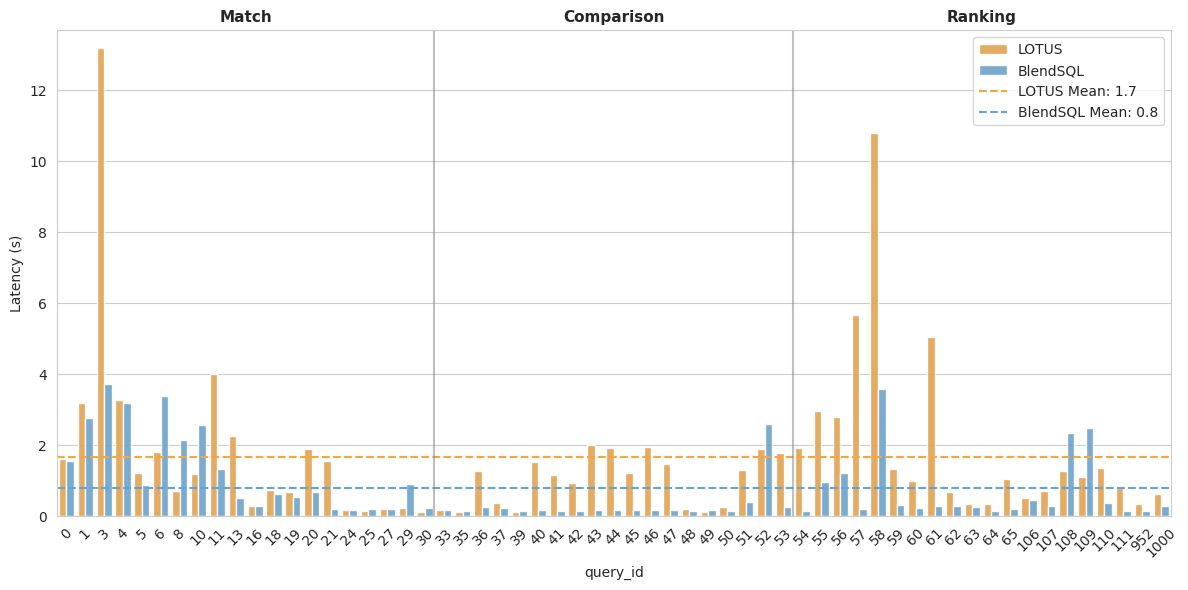

In [25]:
# Set aesthetic parameters
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create the main bar plot
ax = sns.barplot(
    x="query_id",
    y="Latency (s)",
    hue="Program",
    data=df,
    palette=["#FAA43A", "#5DA5DA", "#FF0000"],
    alpha=0.9,
)

# Add mean lines
lotus_mean = avg_sample_level_lotus.mean()
plt.axhline(
    y=lotus_mean, color="#FAA43A", linestyle="--", label=f"LOTUS Mean: {avg_sample_level_lotus.mean():.1f}"
)

blendsql_mean = avg_sample_level_blendsql.mean()
plt.axhline(
    y=blendsql_mean, color="#5DA5DA", linestyle="--", label=f"BlendSQL Mean: {blendsql_mean:.1f}"
)

# Find boundaries between query types
query_type_changes = []
query_type_labels = []
prev_type = None

# Get unique query_ids in order they appear in the data
unique_queries = df['query_id'].unique()
query_to_type = df.drop_duplicates('query_id').set_index('query_id')['Query Type'].to_dict()

for i, qid in enumerate(unique_queries):
    curr_type = query_to_type[qid]
    if curr_type != prev_type:
        if prev_type is not None:
            # Add vertical line at the boundary (between previous and current)
            query_type_changes.append(i - 0.5)
        query_type_labels.append((i, curr_type))
        prev_type = curr_type

# Add vertical grey lines to separate query types
for boundary in query_type_changes:
    ax.axvline(x=boundary, color='grey', linestyle='-', linewidth=1.5, alpha=0.5)

# Add query type labels above each section
y_max = df['Latency (s)'].max()
for start_idx, query_type in query_type_labels:
    # Find the end of this section
    end_idx = len(unique_queries)
    for i in range(start_idx + 1, len(unique_queries)):
        if query_to_type[unique_queries[i]] != query_type:
            end_idx = i
            break

    # Calculate center position for the label
    center_idx = (start_idx + end_idx - 1) / 2

    # Add text label
    ax.text(center_idx, y_max * 1.05, query_type,
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Adjust y-axis to make room for labels
ax.set_ylim(0, y_max + 0.5)

# Improve legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles, labels=labels, title="", loc="upper right", frameon=True
)

plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.savefig("latency_stats.png", dpi=1200)